In [41]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

# Load data
data_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\final_data_filtered_ohe.csv"
df = pd.read_csv(data_path, delimiter=',')
df.columns

Index(['sample', 'wc', 'vm', 'fc', 'ac', 'c', 'h', 'o', 'n', 's', 'cl', 'hc',
       'oc', 'lhv', 'temperature', 'residence_time', 'pressure', 'heat_rate',
       'fuel_type', 'devol_yield', 'fuel_category_Biomass',
       'fuel_category_Coal', 'fuel_category_Mix', 'fuel_category_Plastic'],
      dtype='object')

In [42]:
fuel_types = df['fuel_type'].unique()
# Small epsilon to avoid division by zero
epsilon = 1e-6

# Create new ratio features
df['vm_fc_ratio'] = df['vm'] / (df['fc'] + epsilon)
df['ac_fc_ratio'] = df['ac'] / (df['fc'] + epsilon)
min_vm_fc_ratio = df['vm_fc_ratio'].min()
max_ac_fc_ratio = df['ac_fc_ratio'].max()
min_ac_fc_ratio = df['ac_fc_ratio'].min()
max_vm_fc_ratio = df['vm_fc_ratio'].max()

# Update feature list
feature_cols = [
    'h', 'wc', 'c', 'lhv', 'o', 'n', 's', 'cl',
    'hc', 'oc', 'temperature', 'residence_time', 'pressure', 'heat_rate',
    'vm_fc_ratio', 'ac_fc_ratio'
]

# Also update min-max bounds accordingly (you may compute new ranges empirically or just fit on full data)


# These are your original min and max values (as from your summary)
min_values = {
    'wc': 2.6, 'vm': 44.2, 'fc': 3.064326, 'ac': 0.0, 'c': 32.4, 'h': 3.265 , 'lhv': 13.528,
    'o': 7.0, 'n': 0.269662, 's': 0.04642, 'cl': 0.0, 'hc': 0.7, 'oc': 0.0,
    'temperature': 200, 'residence_time': 0.5, 'pressure': 0.5, 'heat_rate': 10, 'vm_fc_ratio': min_vm_fc_ratio, 'ac_fc_ratio': min_ac_fc_ratio
}
max_values = {
    'wc': 10.8, 'vm': 91.735674, 'fc': 44.5, 'ac': 37.52, 'c': 82.3, 'h': 10.13205, 'lhv': 35.8,
    'o': 54.936839, 'n': 3.9, 's': 2.5, 'cl': 1.5, 'hc': 1.857, 'oc': 1.04402, 'temperature': 1200, 'residence_time': 20, 'pressure': 20, 'heat_rate': 1000, 'vm_fc_ratio':max_vm_fc_ratio, 'ac_fc_ratio': max_ac_fc_ratio}

# Optional: define a margin (e.g. 10%)
margin_ratio = 0.4

# Create expanded bounds
expanded_bounds = {}
for feat in feature_cols:
    min_val = min_values[feat]
    max_val = max_values[feat]
    range_val = max_val - min_val
    new_min = min_val - range_val * margin_ratio
    if new_min < 0:
        new_min = 0
    new_max = max_val + range_val * margin_ratio
    expanded_bounds[feat] = (round(new_min, 3), round(new_max, 3))

# Prepare fake data to fit the scaler
X_bounds = pd.DataFrame({col: [expanded_bounds[col][0], expanded_bounds[col][1]] for col in feature_cols})

# Fit a global scaler based on the expanded bounds
scaler = MinMaxScaler()
scaler.fit(X_bounds)

# Store results
results = []

# Iterate over each fuel type
for test_fuel in fuel_types:
    print(f"Processing fuel type: {test_fuel}")

    # Train-test split
    train_data = df[df['fuel_type'] != test_fuel].drop(columns=['fuel_type']).reset_index(drop=True)
    test_data = df[df['fuel_type'] == test_fuel].drop(columns=['fuel_type']).reset_index(drop=True)

    X_train = train_data.drop(columns=['sample', 'devol_yield'])
    y_train = train_data['devol_yield']
    X_test = test_data.drop(columns=['sample', 'devol_yield'])
    y_test = test_data['devol_yield']
    print(X_train.head())
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).drop(['vm','c','h', 'wc', 'fc', 'ac'], axis=1)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).drop(['vm','c','h', 'wc', 'fc', 'ac'], axis=1)

    base_learners = [
        ("mlp", MLPRegressor(hidden_layer_sizes=(100,), max_iter=2000)),
        ("gbr", GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)),
        ("xgb", xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)),
        ("lgbm", lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1))
    ]

    meta_model = Ridge(alpha=1.0)
    model = StackingRegressor(estimators=base_learners, final_estimator=meta_model, passthrough=True)

    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    results.append({
        "Fuel Type": test_fuel,
        "Score": score
    })

# Save & plot results
results_df = pd.DataFrame(results)
results_df.to_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Systematic_Experiments\Feat_Eng\stacked_results.csv", index=False)
print("✅ Experiment completed! Results saved!")

# === Visualization
plt.figure(figsize=(15, 6))
sns.boxplot(data=results_df, x='Model', y='Score')
plt.xticks(rotation=45)
plt.title("Model Performance Across Fuel Types (R² Score)")
plt.tight_layout()
plt.show()

Processing fuel type: Cellulose
      wc     vm   fc     ac       c      h     o      n      s   cl  ...  \
0  7.345  48.24  6.9  37.52  33.085  3.265  16.6  1.877  0.342  0.0  ...   
1  7.345  48.24  6.9  37.52  33.085  3.265  16.6  1.877  0.342  0.0  ...   
2  7.345  48.24  6.9  37.52  33.085  3.265  16.6  1.877  0.342  0.0  ...   
3  7.345  48.24  6.9  37.52  33.085  3.265  16.6  1.877  0.342  0.0  ...   
4  7.345  48.24  6.9  37.52  33.085  3.265  16.6  1.877  0.342  0.0  ...   

   temperature  residence_time  pressure  heat_rate  fuel_category_Biomass  \
0          200             0.5       1.0       1000                      1   
1          200             0.5       1.0       1000                      1   
2          200             0.5       1.0       1000                      1   
3          200             0.5       1.0       1000                      1   
4          200             1.0       1.0       1000                      1   

   fuel_category_Coal  fuel_category_Mix  

ValueError: Could not interpret value `Model` for `x`. An entry with this name does not appear in `data`.

<Figure size 1500x600 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("MLP Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")

ValueError: array length 78 does not match index length 160

<Figure size 1400x600 with 0 Axes>

(array([ 6., 12., 11., 17.,  8.,  8.,  3.,  7.,  5.,  1.]),
 array([-7.29094867, -3.57490587,  0.14113693,  3.85717973,  7.57322253,
        11.28926533, 15.00530813, 18.72135093, 22.43739373, 26.15343654,
        29.86947934]),
 <BarContainer object of 10 artists>)

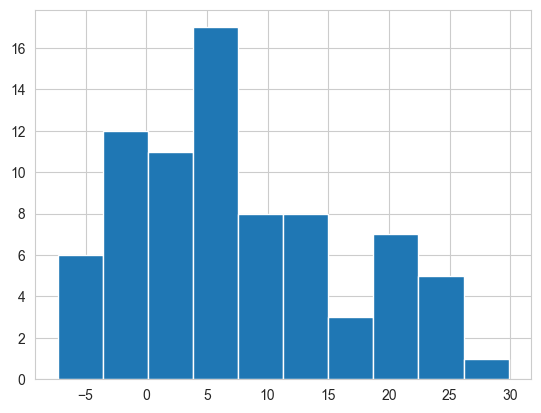

In [18]:
plt.hist(y_pred-y_test)

In [19]:
test_data.shape

(78, 22)